In [1]:
import pandas as pd
import seaborn as sns
import pickle
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import econtools.metrics as mt
import numpy as np
from econtools import read, outreg, table_statrow, write_notes
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import statistics as s 
plt.style.use('seaborn-v0_8-deep')

In [2]:
original_df = pd.read_csv(
    r'C:\Users\faxul\Google Drive\RamirezRepStudy\thesisminusdata\TradeCode\paper_repstudy\notFeelingTheBuzz\Datafiles\clegg_matches_cleaned.csv')
fitset = original_df[~(original_df['date'] > '2019-01-00')].copy()
testset = original_df[(original_df['date'] > '2019-01-00')].copy()

testset = testset.dropna(subset=["inverse_b365", "inverse_best"])
filtered_df = testset[testset['inverse_best'] > testset['inverse_b365']]
filtered_df
testset.drop(filtered_df.index, inplace=True)

testset.reset_index(inplace=True)
print('Fit set rows: ' + str(len(fitset)))
print('Test set rows: ' + str(len(testset)))

Fit set rows: 10826
Test set rows: 13885


In [3]:
def fit_regression(rankdist: bool = True):
    if rankdist:
        results = mt.reg(fitset,'outcome',                      
        ['inverse_avg', 'rankdist', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True
        )
        params = [results.beta[-1], results.beta[0], results.beta[1], results.beta[2]]
        #params= [constant        , inverse_avg    , rankdist       , wikibuzz       ]
        print(results)
    else:
        # No RankDist variable
        results = mt.reg(fitset,'outcome',
        ['inverse_avg', 'wikibuzz'],
        #fe_name= "year",
        cluster='match_id',addcons=True
        )
        params = [results.beta[-1], results.beta[0], results.beta[1]]
        print(results)
    return params

def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    if (rankdist is not None) & (wikibuzz is not None):
        y_hat = params[0] + params[-3]*inverse_odds + params[-2]*rankdist + params[-1]*wikibuzz
    if (rankdist is not None) & (wikibuzz is None):
        y_hat = params[0] + params[-2] * inverse_odds + params[-1] * rankdist
    if (wikibuzz is not None) & (rankdist is None):
        y_hat = params[0] + params[-2]*inverse_odds + params[-1]*wikibuzz
    return y_hat

def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    k = max(y_hat - ((1 - y_hat)/(odds - 1)), 0)
    return k 

def profit_loss(kelly, odds_implied_prob, outcome):
    odds = 1 / odds_implied_prob
    if outcome == 1:
        PnL = kelly*odds - kelly
    if outcome == 0:
        PnL = -kelly
    return PnL

def show_results(testset, params, odds, rankdist: bool = True): # Odds = "avg", "best", "b365"

    # Estimate Probability.
    if rankdist:
        testset['model_est_prob'] = [estimate_probability(params, row[0], row[1], row[2]) for row in zip(testset['inverse_avg'],
                                                                                                         testset['rankdist'],
                                                                                                         testset['wikibuzz'])]
    else:
        testset['model_est_prob'] = [estimate_probability(params, inverse_odds=row[0], wikibuzz=row[1]) for row in zip(testset['inverse_avg'],
                                                                                                                       testset['wikibuzz'])]
    # Determine kelly bet size.
    testset['kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)],
                                                                               testset['model_est_prob'])]
    # Calculate return for the bet.
    testset['PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)],
                                                                         testset['outcome'])]

    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute return: '+str(testset['PnL'].sum()))
    print('Absolute amount bet: '+str(testset['kelly_betsize'].sum()))
    print('ROI (%): '+str((((testset['PnL'].sum() + testset['kelly_betsize'].sum())/testset['kelly_betsize'].sum())-1)*100))

def plot_results():
    testset['Cum_PnL'] = testset['PnL'].cumsum() * 100
    testset["bankroll_after"] += -1 
    testset["bankroll_after"] *= 100
    
    plt.rcParams.update({'font.size': 11})
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    testset.plot('date', ['Cum_PnL', "bankroll_after"], ax=ax, linewidth=1.5)
    ax.set_ylabel('Cumulative Profit (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    plt.show()
    
def correct_kelly_results(odds, rankdist: bool = True): # Odds = "avg", "best", "b365"
    
    if rankdist == True:
        params = fit_regression(rankdist=True)
    else:
        params = fit_regression(rankdist=False)
    show_results(testset, params, odds, rankdist)
    
    testset["fixed_kelly"] = testset['kelly_betsize']
    
    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before'] 
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before'] 
    
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))

In [27]:
params = fit_regression(rankdist=True)
show_results(testset, params=params, odds="best", rankdist=True)
# Set initial bankroll
initial_bankroll = 1000

# Calculate cumulative returns with changing bankroll
def calculate_cumulative_returns(data, initial_bankroll):
    data['cumulative_pnl'] = 0.0
    current_bankroll_wrong = initial_bankroll
    current_bankroll_proper = initial_bankroll
    
    for i, row in data.iterrows():
        frac_kelly = row['PnL']
        
        current_bankroll_wrong += frac_kelly * initial_bankroll
        data.at[i, 'cumulative_pnl_wrong'] = current_bankroll_wrong

        current_bankroll_proper += frac_kelly * current_bankroll_proper
        data.at[i, 'cumulative_pnl_proper'] = current_bankroll_proper

    return data

cumpnls_wrong = []
cumpnls_proper = []
strategy_stops_counter = 0

for i in range(0, 100):
    
    testset_it = testset.sample(frac=0.75).reset_index(drop=True)
    # Call the function with your data
    result = calculate_cumulative_returns(testset_it, initial_bankroll)
    min_index = result["cumulative_pnl_wrong"].idxmin()
    if result.loc[min_index, 'cumulative_pnl_wrong'] < 0:
        cumpnls_wrong.append(0)
    elif (result.loc[min_index, 'cumulative_pnl_wrong'] > 0) & ((result.loc[min_index, 'kelly_betsize'] * 1000 ) > result.loc[min_index, 'cumulative_pnl_wrong']):
        cumpnls_wrong.append(result.loc[min_index, 'cumulative_pnl_wrong'])
        strategy_stops_counter += 1
    else:
        cumpnls_wrong.append(result["cumulative_pnl_wrong"].iloc[-1])

    cumpnls_proper.append(result["cumulative_pnl_proper"].iloc[-1])
    

Dependent variable:	outcome
N:			10816
R-squared:		0.1595
Estimation method:	OLS
VCE method:		Cluster
  Cluster variable:	  match_id
  No. of clusters:	  5408
             coeff    se      t   p>t CI_low CI_high
inverse_avg  1.043 0.033 31.283 0.000  0.977   1.108
rankdist     0.068 0.041  1.675 0.094 -0.012   0.147
wikibuzz     0.008 0.005  1.530 0.126 -0.002   0.018
_cons       -0.050 0.018 -2.847 0.004 -0.085  -0.016

Bets considered (2 * Matches): 13885
Number of bets placed: 7148
Mean overround (%): -0.5122072416349877
Absolute return: 8.841301701307243
Absolute amount bet: 274.80352210138
ROI (%): 3.2173174614718247


In [37]:
# Saving the lists to a file using pickle
# with open('full_kelly_lists.pickle', 'wb') as file:
#     pickle.dump(cumpnls_wrong, file)
#     pickle.dump(cumpnls_proper, file)

#Loading the lists from the file using pickle
with open('full_kelly_lists.pickle', 'rb') as file:
    cumpnls_wrong = pickle.load(file)
    cumpnls_proper = pickle.load(file)

In [38]:
cumpnls_wrong_returns = [((x- 1000)) for x in cumpnls_wrong]
cumpnls_proper_returns = [((x- 1000)) for x in cumpnls_proper]

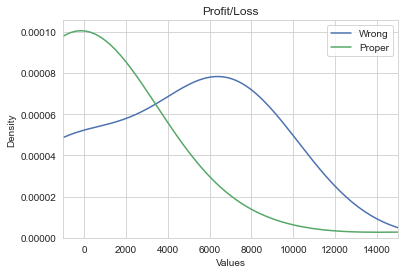

In [32]:
sns.kdeplot(cumpnls_wrong_returns, label="Wrong", bw_adjust=2)
sns.kdeplot(cumpnls_proper_returns, label="Proper", bw_adjust=2)

# Set the title and labels
plt.title('Profit/Loss')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.xlim(-1000,15000)

# Show the plot
plt.show()

In [36]:
count = sum(1 for x in cumpnls_proper_returns if x < -900)

print(count) # output: 1
print(strategy_stops_counter)

16
2


In [43]:
sum(cumpnls_proper_returns)

23321403.04427068

In [60]:
np.std(cumpnls_wrong)

4075.294914275267

In [39]:
(s.mean(cumpnls_proper_returns) / np.std(cumpnls_proper_returns)) - (s.mean(cumpnls_wrong_returns) / np.std(cumpnls_wrong_returns))

-0.8029514280925194

In [10]:
s.mean(cumpnls_proper_returns)

2332.1403044270724

In [44]:
s.mean(cumpnls_wrong_returns)

3971.299344229857